This will model the bump attractor diffusion and bias without the need for NN to make it computationally tractable for the agent simulations. 
We simulate a wait period of 48hours because in Ziegler1997 the homing distance drop of the ants in this period is imperceptible so the only factor is the dispertion due to stochastic drift. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.stats import normaltest
from scipy.stats import shapiro
from scipy.stats import norm
from utility_functions import *

%matplotlib inline

In [3]:
def calc_theta_mean_absolute_deviation_rate(plot_items_dict, plot_keys_list, start_time=0, end_time=1, percentage=False):
    """ Gets 
            percentile : False for the maximum and minimum sample value or 
                         a number for calculating the median of the first <number>% samples 
                         and the last <number>% samples.
    """
    if isinstance(start_time, Quantity):
        start_time = start_time / second
    if isinstance(end_time, Quantity):
        end_time = end_time / second
    
    for plot_key in plot_keys_list:
        plot_item = plot_items_dict[plot_key]
        if plot_item is not None:
            theta_ts_abs_diff_mean = plot_item['theta_ts_abs_diff_mean']
            t_snapshots = plot_item['t_snapshots']

            if isinstance(t_snapshots, Quantity):
                t_snapshots = t_snapshots / second

            index_start_time = np.argmax(t_snapshots >= start_time)
            index_end_time = np.argmin(t_snapshots <= end_time)
            
            theta_ts_abs_diff_mean_segment = theta_ts_abs_diff_mean[index_start_time:index_end_time]
            if not percentage:
                delta_theta_ts_abs_diff_mean_segment = np.max(theta_ts_abs_diff_mean_segment) - np.min(theta_ts_abs_diff_mean_segment)
            else:
                a = theta_ts_abs_diff_mean_segment
                first_portion_median = np.median(a[0:int(len(a)*percentage/100)])
                last_portion_median = np.median(a[len(a)-int(len(a)*percentage/100):len(a)])
                delta_theta_ts_abs_diff_mean_segment = last_portion_median - first_portion_median
            delta_time = end_time - start_time
            
            theta_mean_absolute_deviation_rate = delta_theta_ts_abs_diff_mean_segment / delta_time
            plot_items_dict[plot_key]['theta_mean_absolute_deviation_rate'] = theta_mean_absolute_deviation_rate
    
    return plot_items_dict

def print_theta_mean_absolute_deviation_rate(plot_items_dict, plot_keys_list, plot_key_str, plot_key_units):
    c1w = max(len(plot_key_str), len(plot_key_units))
    print(('{:^'+str(c1w)+'} {:^10}').format(plot_key_str,  'Drift rate'))
    print(('{:^'+str(c1w)+'} {:^10}').format(plot_key_units, '(°/s)'))
    for plot_key in plot_keys_list:
        plot_item = plot_items_dict[plot_key]
        if plot_item is not None:
            theta_mean_absolute_deviation_rate = plot_item['theta_mean_absolute_deviation_rate']
            print(('{:'+str(c1w)+'} {:10}').format(plot_key, theta_mean_absolute_deviation_rate))



The top-left plot shows multiple random walks starting from the same value 0m.
The median walk location (value) across trials and time is 0.0413m (plot down-left).
With random walk parameter σ=0.0055 the value diffusion rate is MAD=9.62423556217666e-06m/s which is equal to 0.0346m/h (a difference of 1.9% from 0.034m/h).
The final location (value) distribution of the walks fit a Gaussian distribution with μ=0.06851922713784615 and σ_2=1.614993141975769
The empirical expectation is these data should fit a Gaussian with μ=0 and σ_2=sqrt(duration)*σ=1.6166632302368975.
Thus the empirical estimate of σ_2 is 0.1% off mark from the one we measured.

Summary of the above
With random walk parameter σ=0.0055 the diffusion is MAD=9.62423556217666e-06m/s which is equal to 0.0346m/h (a difference of 1.9% from the ant 0.034m/h).
The empirical expectation was that the final walk locations distribution will fit a Gaussian with μ=0 and σ_2=sqrt(duration)*σ=1.6166632302368975. We measured a σ_2=1.614993

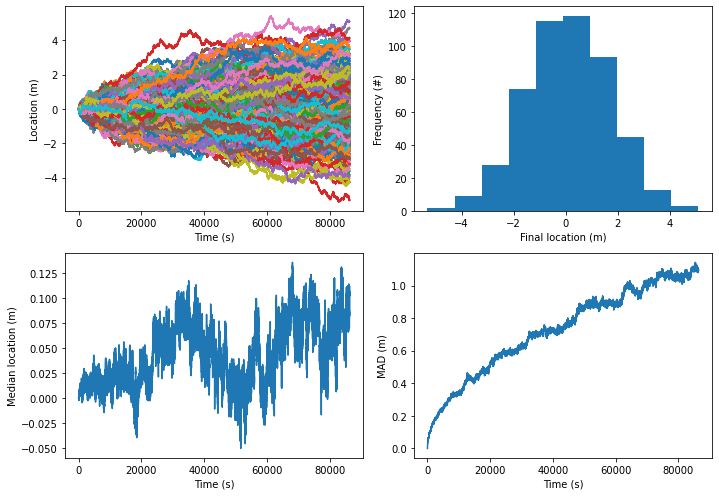

In [31]:
# Generate random walks (Wiener process that is 1D Brownian motion) x <trials> with initial value 0

trials = 500 # Number of random walks to generate
noiseless_value = 0 # Initial location of each walk
duration = 60 * 60 * 24 * 1 # 1 day in sec. Duration of each random walk (ant waiting period)

# This results in diffusion rate 0.0346m/h which is the closest match to the ants 0.034m/h = 0.0000094m/s
SDsigma = 0.0055 # Results in 'theta_mean_absolute_deviation_rate': 9.62423556217666e-06m/s (which is equal to 0.0346m/h)

def simulate_random_walks(trials, noiseless_value, duration, SDsigma, show_plots=True, show_details=True):
    noise_trials_value_ts = []
    
    if show_plots:
        fig, axs = plt.subplots(2, 2, figsize=(10, 7))

    for trial in range(trials):
        value = noiseless_value # initial location
        value_ts = []

        #for t in range(0, duration):
        #    value += np.random.normal(loc=0, scale=SDsigma)
        #    value_ts.append(value)
        # Alternative 1: optimising
        #rand_samples = np.random.normal(loc=0, scale=SDsigma, size=duration)
        #for t in range(0, duration):
        #    value += rand_samples[t] 
        #    value_ts.append(value)
        # Alternative 2: optimising further (now first element is the initial value so we remove the last to maintain length)
        rand_samples = np.random.normal(loc=0, scale=SDsigma, size=duration)
        value_ts = np.cumsum(np.concatenate(([noiseless_value], rand_samples)))[:-1]

        if show_plots:
            axs[0,0].plot(value_ts)
        #noise_trials_value_ts.append(np.array(value_ts))
        # Alternative 2: now value_ts is already a numpy array
        noise_trials_value_ts.append(value_ts)

    if show_plots:
        axs[0,0].set_xlabel('Time (s)')
        axs[0,0].set_ylabel('Location (m)')        

    if show_details:
        print('The top-left plot shows multiple random walks starting from the same value {}m.'.format(noiseless_value))
        
    mad = median_absolute_deviation(noiseless_value, noise_trials_value_ts)
    t_snapshots = np.linspace(0, duration, duration)


    # Plot the mean location over all trials, must be ΔLocation = 0
    median_ts = np.median(noise_trials_value_ts, axis=0)
    if show_plots:
        axs[1,0].plot(t_snapshots, median_ts)
        #axs[1,0].set_ylim([-0.05, 0.05])
        axs[1,0].set_xlabel('Time (s)')
        axs[1,0].set_ylabel('Median location (m)')    
    if show_details:
        print('The median walk location (value) across trials and time is {:.3}m (plot down-left).'.format(np.median(median_ts)))


    # Plot the median absolute deviation over trials, must 
    # be 0.034m/h with appropriate SDsigma choice (SDsigma = 0.0009)
    if show_plots:
        axs[1,1].plot(t_snapshots, mad)
        #axs[1,1].set_ylim([-0.05, 0.05])
        axs[1,1].set_xlabel('Time (s)')
        axs[1,1].set_ylabel('MAD (m)')


    # Calculate the diffusion rate of the above
    # With SDsigma = 0.0009 above results in 'theta_mean_absolute_deviation_rate': 0.0000096m/s 
    # (ants exhibit 0.034m/h = 0.0000094m/s) which is very close
    mad_dict = {}
    mad_dict['mad'] = {}
    mad_dict['mad']['theta_ts_abs_diff_mean'] = mad
    mad_dict['mad']['t_snapshots'] = t_snapshots
    error_calc = calc_theta_mean_absolute_deviation_rate(mad_dict, ['mad'], start_time=20000, end_time=duration-100, percentage=False)
    error_calc
    if show_details:
        print('With random walk parameter σ={:} the value diffusion rate is MAD={}m/s which is equal to {:.3}m/h (a difference of {:.2}% from 0.034m/h).'.format(SDsigma, error_calc['mad']['theta_mean_absolute_deviation_rate'], error_calc['mad']['theta_mean_absolute_deviation_rate']*60*60, (error_calc['mad']['theta_mean_absolute_deviation_rate']*60*60 - 0.034)/0.034*100))


    # Plot the distribution of the bump location (values) at the end of the above simulations
    last_loc_slice = np.array(noise_trials_value_ts)[:,-1]
    if show_plots:
        axs[0,1].hist(last_loc_slice)
        axs[0,1].set_xlabel('Final location (m)')
        axs[0,1].set_ylabel('Frequency (#)')        

    if show_plots:
        fig.tight_layout()

    # Test normality, if p<0.05 the null hypothesis that the data are not different from normal distribution is rejected
    normaltest(last_loc_slice), shapiro(last_loc_slice)

    # Estimate normal distribution parameters
    from scipy.stats import norm
    mu, std = norm.fit(last_loc_slice)
    if show_details:
        print('The final location (value) distribution of the walks fit a Gaussian distribution with μ={} and σ_2={}'.format(mu, std))


    # Apploximation of the standard deviation of the final values distribution.
    # By trying different duration and SDsigma values in the above computations 
    # I concluded that the Standard Deviation (σ) of the normally distributed 
    # end locations (values) of random walks (Brownian motion or Wiener process)
    # is given by this formula
    norm_dist_sigma = np.sqrt(duration) * SDsigma
    if show_details:
        print('The empirical expectation is these data should fit a Gaussian with μ=0 and σ_2=sqrt(duration)*σ={:}.'.format(norm_dist_sigma))


    approximation_error = np.abs(std - norm_dist_sigma)
    if show_details:
        print('Thus the empirical estimate of σ_2 is {:.2}% off mark from the one we measured.'.format((norm_dist_sigma-std)/std*100))
    
    return (error_calc['mad']['theta_mean_absolute_deviation_rate'], norm_dist_sigma, std)


mad, expected_std, measured_std = simulate_random_walks(trials, noiseless_value, duration, SDsigma)

print()
print('Summary of the above')
print('With random walk parameter σ={:} the diffusion is MAD={}m/s which is equal to {:.3}m/h (a difference of {:.2}% from the ant 0.034m/h).'.format(SDsigma, mad, mad*60*60, (mad*60*60 - 0.034)/0.034*100))
print('The empirical expectation was that the final walk locations distribution will fit a Gaussian with μ=0 and σ_2=sqrt(duration)*σ={:}. We measured a σ_2={:}.'.format(expected_std, measured_std))
print('Thus the empirical estimate of σ_2 is {:.2}% off mark from the one we measured.'.format((expected_std-measured_std)/measured_std*100))



Now we explore a range of σ values to find the one that produces diffusion rate closest to 0.034m/h.

Walk noise Diffusion Diff. diff.  Final σ diff.
    σ         m/h         %            %      
0.00400000     0.025       -25.66        -0.39
0.00405000     0.025       -26.67         0.37
0.00410000     0.025       -26.91         0.42
0.00415000     0.025       -25.56         0.31
0.00420000     0.026       -23.92        -0.62
0.00425000     0.025       -25.13         0.87
0.00430000     0.027       -19.62        -0.15
0.00435000     0.027       -20.44        -0.35
0.00440000     0.027       -21.38         0.63
0.00445000     0.028       -16.97        -0.03
0.00450000     0.029       -15.96        -0.93
0.00455000     0.029       -15.45        -0.21
0.00460000     0.029       -15.72        -0.08
0.00465000     0.029       -15.26        -0.26
0.00470000     0.029       -14.60        -0.53
0.00475000     0.029       -14.84         0.61
0.00480000     0.029       -15.34         0.80
0.00485000     0.030       -11.17         0.05
0.00490000     0.030       -11.15        -0.36
0.00495000  

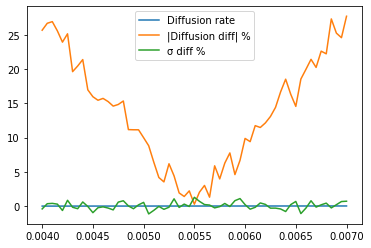

In [11]:
set_of_SDsigma = np.linspace(0.0008, 0.0009, num=21)
set_of_SDsigma = np.linspace(0.00085, 0.00086, num=21)
set_of_SDsigma = np.linspace(0.00084, 0.00087, num=61)

set_of_SDsigma = np.linspace(0.004, 0.007, 61)

print('{:^10} {:^9} {:^12} {:^12}'.format('Walk noise', 'Diffusion', 'Diff. diff.', 'Final σ diff.'))
print('{:^10} {:^9} {:^12} {:^12}'.format('σ', 'm/h', '%', '%'))

fitness_results = []

# For each of the random walk Gaussian noise σ values calculate
for SDsigma in set_of_SDsigma:

    # Get the average of 40 trials
    one_sigma_fitness_results = []
    for i in range(40):
        mad, expected_std, measured_std = simulate_random_walks(trials, noiseless_value, duration, SDsigma, show_plots=False, show_details=False)
        
        one_sigma_fitness_results.append([SDsigma, mad*60*60, (mad*60*60 - 0.034)/0.034*100, (expected_std-measured_std)/measured_std*100])
        
        #print('{:10.6} {:10.3} {:14.2} {:14.2}'.format(SDsigma, mad*60*60, (mad*60*60 - 0.034)/0.034*100, (expected_std-measured_std)/measured_std*100))
    
    mean_results = np.median(one_sigma_fitness_results, axis=0)
    fitness_results.append(mean_results)
    print('{:10.8f} {:9.3f} {:12.2f} {:12.2f}'.format(*mean_results))

SDsigma = np.array(fitness_results)[:,0]
diffusion = np.array(fitness_results)[:,1]
diff_diff_perc = np.array(fitness_results)[:,2]
SDsigma_diff_perc = np.array(fitness_results)[:,3]

plt.plot(SDsigma, diffusion, label='Diffusion rate')
plt.plot(SDsigma, np.abs(diff_diff_perc), label='|Diffusion diff| %')
plt.plot(SDsigma, SDsigma_diff_perc, label='σ diff %')
plt.legend()

best_sigma = SDsigma[np.argmin(np.abs(diff_diff_perc))]
print()
print('The σ resulting to the closest match to producing a diffusion rate of 0.034m/h is with σ={}'.format(best_sigma))


From the above we observe that creating Brownian motion with N(0, SDsigma = 0.0055) 
results in Gaussian distributed end values with N(0, σ_2), σ_2=0.0482. That is approximatelly 
equal to np.sqrt(duration) * SDsigma.

From https://www.randomservices.org/random/brown/Standard.html
    ''Run the simulation of the standard Brownian motion process a few times with t=5''
    Under the plots in the pop up window says that the final position X, has the normal distribution with mean 0 and standard deviation sqrt(t).

The minimum diffusion rate error is given for σ=0.005836734693877551
The fitted curve parameters were  (11040891.483841648, 0.005504034092024939, 5.2479326219170295)


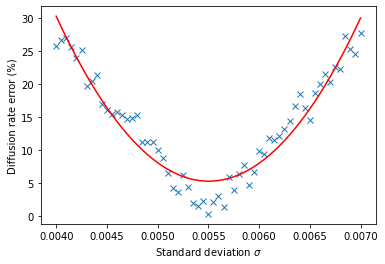

In [30]:
# The data are noisy so lets fit a curve and find its minimum instead
from scipy.optimize import curve_fit

def func1(x, a, b, c, d):
    return a*(x-b)**2 + c*x + d

def func2(x, a, b, c):
    return a*(x-b)**2 + c

func = func1
p0 = [10000000000, 0.0055, 0, 5]

func = func2
p0 = [10000000000, 0.0055, 0]

xdata = SDsigma
ydata = np.abs(diff_diff_perc)

plt.plot(xdata, ydata, 'x')

xvalues = np.linspace(np.min(xdata), np.max(xdata))
popt, pcov = curve_fit(func, xdata, ydata, p0=p0)
yvalues = func(xdata, *popt)
#plt.plot(xdata, yvalues, 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
plt.plot(xdata, yvalues, 'r-')
#plt.legend()
plt.xlabel('Standard deviation $\sigma$')
plt.ylabel('Diffusion rate error (%)')

save_plots = False
if save_plots:
    fig.savefig('Results/Images/optimum-random-walk-sigma.svg')

print('The minimum diffusion rate error is given for σ={}'.format(xvalues[np.argmin(yvalues)]))
#print('The fitted curve parameters were a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
print('The fitted curve parameters were ', tuple(popt))

We should run homing simulations after accumulating diffusion error for these waiting periods

In [4]:
# We should run homing simulations after accumulating diffusion error for these waiting periods
wait_duration_hours = np.array([1, 24, 48, 96, 192]) # hours waiting before release
rand_walk_std=0.0055

mem_noise_std = np.sqrt(wait_duration_hours * 60 * 60) * rand_walk_std
mem_noise_std

array([0.33      , 1.61666323, 2.28630707, 3.23332646, 4.57261413])

In [5]:
# Scale them in the context of the physical space represented in memory.
# Say the maximum distance range is 128m then the standard deviation would be divided by this distance
mem_noise_std / 128

array([0.00257812, 0.01263018, 0.01786177, 0.02526036, 0.03572355])